# Import Data

In [ ]:
!wget https://filebin.net/trsh6uhonv07jvum/17flowers_labeled.zip
!unzip 17flowers_labeled

--2022-11-25 07:46:56--  https://filebin.net/trsh6uhonv07jvum/17flowers_labeled.zip
Resolving filebin.net (filebin.net)... 185.47.40.36, 2a02:c0:2f0:700:f816:3eff:feac:c605
Connecting to filebin.net (filebin.net)|185.47.40.36|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2022-11-25 07:46:57 ERROR 404: Not Found.

unzip:  cannot find or open 17flowers_labeled, 17flowers_labeled.zip or 17flowers_labeled.ZIP.


In [ ]:
import os
def walk_through_dir(dir_path):
  """
  Walks through dir_path returning its contents.
  Args:
    dir_path (str or pathlib.Path): target directory
  
  Returns:
    A print out of:
      number of subdiretories in dir_path
      number of images (files) in each subdirectory
      name of each subdirectory
  """
  for dirpath, dirnames, filenames in os.walk(dir_path):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")


walk_through_dir("17flowers")

There are 17 directories and 2 images in '17flowers'.
There are 0 directories and 80 images in '17flowers/Tigerlily'.
There are 0 directories and 80 images in '17flowers/Iris'.
There are 0 directories and 80 images in '17flowers/Daisy'.
There are 0 directories and 80 images in '17flowers/LilyValley'.
There are 0 directories and 80 images in '17flowers/Dandelion'.
There are 0 directories and 80 images in '17flowers/Sunflower'.
There are 0 directories and 80 images in '17flowers/Colts'Foot'.
There are 0 directories and 80 images in '17flowers/Cowslip'.
There are 0 directories and 80 images in '17flowers/Daffodil'.
There are 0 directories and 80 images in '17flowers/Snowdrop'.
There are 0 directories and 80 images in '17flowers/Crocus'.
There are 0 directories and 80 images in '17flowers/Windflower'.
There are 0 directories and 80 images in '17flowers/Buttercup'.
There are 0 directories and 80 images in '17flowers/Fritillary'.
There are 0 directories and 80 images in '17flowers/Pansy'.
Th

In [ ]:
!pip install split-folders
!rm -rf /content/train_data

import splitfolders

splitfolders.ratio("17flowers", # The location of dataset
                   output="train_data", # The output location
                   seed=42, # The number of seed
                   ratio=(.7, .2, .1), # The ratio of splited dataset - 70% train, 15% validation, 15% test
                   group_prefix=None, # If your dataset contains more than one file like ".jpg", ".pdf", etc
                   move=False # If you choose to move, turn this into True
                   )

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


Copying files: 1360 files [00:00, 5886.17 files/s]


In [ ]:
image_path = "/content/train_data"
# Setup train and testing paths
train_dir = image_path + "/train"
test_dir = image_path + "/test"
val_dir = image_path + "/val"

train_dir, test_dir, val_dir

('/content/train_data/train',
 '/content/train_data/test',
 '/content/train_data/val')

# Densenet Model

In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch import Tensor
import time
import os

In [ ]:
class _Transition(nn.Sequential):
  def __init__(self, num_input_features, num_output_features):
    super(_Transition, self).__init__()
    self.add_module("norm", nn.BatchNorm2d(num_input_features))
    self.add_module("relu", nn.ReLU(inplace=True))
    self.add_module("conv", nn.Conv2d(num_input_features, num_output_features, kernel_size=1, stride=1, bias=False))
    self.add_module("pool", nn.AvgPool2d(kernel_size=2, stride=2))

In [ ]:
class _DenseLayer(nn.Module):
  def __init__(self, num_input_features, growth_rate, bn_size, drop_rate, memory_efficient=False):
    super(_DenseLayer, self).__init__()
    self.add_module("norm1", nn.BatchNorm2d(num_input_features))
    self.add_module('relu1', nn.ReLU(inplace=True))
    self.add_module('conv1', nn.Conv2d(num_input_features, bn_size * growth_rate, kernel_size=1, stride=1, bias=False))
    self.add_module('norm2', nn.BatchNorm2d(bn_size * growth_rate))
    self.add_module('relu2', nn.ReLU(inplace=True))
    self.add_module('conv2', nn.Conv2d(bn_size * growth_rate, growth_rate, kernel_size=3, stride=1, padding=1, bias=False))
    self.drop_rate = float(drop_rate)
    self.memory_efficient = memory_efficient

  def bn_function(self, inputs):
    "Bottleneck function"
    # type: (List[Tensor]) -> Tensor
    concated_features = torch.cat(inputs, 1)
    bottleneck_output = self.conv1(self.relu1(self.norm1(concated_features)))  # noqa: T484
    return bottleneck_output
    
  def forward(self, input):  # noqa: F811
    if isinstance(input, Tensor):
      prev_features = [input]
    else:
      prev_features = input
    bottleneck_output = self.bn_function(prev_features)
    new_features = self.conv2(self.relu2(self.norm2(bottleneck_output)))
    if self.drop_rate > 0:
      new_features = F.dropout(new_features, p=self.drop_rate, training=self.training)
    return new_features





In [ ]:
class _DenseBlock(nn.ModuleDict):
  _version = 2
  def __init__(self, num_layers, num_input_features, bn_size, growth_rate, drop_rate, memory_efficient=False):
    super(_DenseBlock, self).__init__()
    for i in range(num_layers):
      layer = _DenseLayer(
        num_input_features + i * growth_rate,
        growth_rate=growth_rate,
        bn_size=bn_size,
        drop_rate=drop_rate,
        memory_efficient=memory_efficient,
      )
      self.add_module('denselayer%d' % (i + 1), layer)
  def forward(self, init_features):
    features = [init_features]
    for name, layer in self.items():
        new_features = layer(features)
        features.append(new_features)
    return torch.cat(features, 1)

In [ ]:
from collections import OrderedDict
class DenseNet(nn.Module):
  # hyperpar=growth_rateameters:
    # Dense Block #layers = choose how many layers within denseblock 
    # Growth rate = #features outputed by each layer
    # Bottleneck size = #features to reduce past layers to before current(bn_size*growth rate) layer conv
    # drop rate
  def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16), num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):
    super(DenseNet, self).__init__()
    # Initial Conv, Pool - input 224x224x3, output 56x56x64
    self.features = nn.Sequential(OrderedDict([
      ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                          padding=3, bias=False)),
      ('norm0', nn.BatchNorm2d(num_init_features)),
      ('relu0', nn.ReLU(inplace=True)),
      ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    # growth_rate=8, bn_size=4*growth_rate, drop_rate=0
    bn_size = 4
    growth_rate = 8
    drop_rate = 0

    # Dense Block 1 - input 56x56x64, output 56x56x(64+g*#layers) = 112
    self.features.add_module("denseblock1", _DenseBlock(num_layers=6, num_input_features=64, bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate, memory_efficient=False))
    # Transition Layer 1 - output 28x28,((64+g*#layers)/2) = 56
    self.features.add_module("transition1", _Transition(num_input_features=112, num_output_features=56))

    # Dense Block 2 - input 28x28x(prev_output), output 28x28x(prev_output+g*#layers) = 152
    self.features.add_module("denseblock2", _DenseBlock(num_layers=12, num_input_features=56, bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate, memory_efficient=False))
    # Transition Layer 2 - output 14x14x? = 76
    self.features.add_module("transition2", _Transition(num_input_features=152, num_output_features=76))

    # Dense Block 3 - input 14x14x?, output, 14x14x? = 268
    self.features.add_module("denseblock3", _DenseBlock(num_layers=24, num_input_features=76, bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate, memory_efficient=False))
    # Transition Layer 3 - output 7x7x? = 134
    self.features.add_module("transition3", _Transition(num_input_features=268, num_output_features=134))

    # Dense Block 4 - input 7x7x?, output 7x7x? = 262
    self.features.add_module("denseblock4", _DenseBlock(num_layers=16, num_input_features=134, bn_size=bn_size, growth_rate=growth_rate, drop_rate=drop_rate, memory_efficient=False))

    # Final Batch Norm
    self.features.add_module('norm5', nn.BatchNorm2d(262)) #262 = num features outputed from last denseblock
    # Linear Classifer
    self.classifier = nn.Linear(262, 17) #num class is the 17 categories of plant
    # Softmax

    # Official init from torch repo.
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight)
      elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight, 1)
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
          nn.init.constant_(m.bias, 0)
    
  def forward(self, x):
    features = self.features(x)
    out = F.relu(features, inplace=True)
    out = F.adaptive_avg_pool2d(out, (1, 1))
    out = torch.flatten(out, 1)
    out = self.classifier(out)
    return out



In [ ]:
class ExampleDenseNet(nn.Module): # https://amaarora.github.io/2020/08/02/densenets.html
  def __init__(self, growth_rate=32, block_config=(6, 12, 24, 16),
                 num_init_features=64, bn_size=4, drop_rate=0, num_classes=1000, memory_efficient=False):

    super(DenseNet, self).__init__()

    # Convolution and pooling part from table-1
    self.features = nn.Sequential(OrderedDict([
      ('conv0', nn.Conv2d(3, num_init_features, kernel_size=7, stride=2,
                          padding=3, bias=False)),
      ('norm0', nn.BatchNorm2d(num_init_features)),
      ('relu0', nn.ReLU(inplace=True)),
      ('pool0', nn.MaxPool2d(kernel_size=3, stride=2, padding=1)),
    ]))

    # Add multiple denseblocks based on config 
    # for densenet-121 config: [6,12,24,16]
    num_features = num_init_features
    for i, num_layers in enumerate(block_config):
      block = _DenseBlock(
        num_layers=num_layers,
        num_input_features=num_features,
        bn_size=bn_size,
        growth_rate=growth_rate,
        drop_rate=drop_rate,
        memory_efficient=memory_efficient
      )
      self.features.add_module('denseblock%d' % (i + 1), block)
      num_features = num_features + num_layers * growth_rate
      if i != len(block_config) - 1:
        # add transition layer between denseblocks to 
        # downsample
        trans = _Transition(num_input_features=num_features,
                            num_output_features=num_features // 2)
        self.features.add_module('transition%d' % (i + 1), trans)
        num_features = num_features // 2

    # Final batch norm
    self.features.add_module('norm5', nn.BatchNorm2d(num_features))

    # Linear layer
    self.classifier = nn.Linear(num_features, num_classes)

    # Official init from torch repo.
    for m in self.modules():
      if isinstance(m, nn.Conv2d):
          nn.init.kaiming_normal_(m.weight)
      elif isinstance(m, nn.BatchNorm2d):
          nn.init.constant_(m.weight, 1)
          nn.init.constant_(m.bias, 0)
      elif isinstance(m, nn.Linear):
          nn.init.constant_(m.bias, 0)

  def forward(self, x):
    features = self.features(x)
    out = F.relu(features, inplace=True)
    out = F.adaptive_avg_pool2d(out, (1, 1))
    out = torch.flatten(out, 1)
    out = self.classifier(out)
    return out

# Load Data 

In [ ]:
print(torch.cuda.is_available())
device = "cuda" if torch.cuda.is_available() else "cpu"

True


In [ ]:
# Write transform for image
data_transform = transforms.Compose([
    # Resize the images to 64x64
    transforms.Resize(size=(224, 224)),
    # Flip the images randomly on the horizontal
    transforms.RandomHorizontalFlip(p=0.5), # p = probability of flip, 0.5 = 50% chance
    # Turn the image into a torch.Tensor
    transforms.ToTensor() # this also converts all pixel values from 0 to 255 to be between 0.0 and 1.0 
])

# Use ImageFolder to create dataset(s)
from torchvision import datasets
train_data = datasets.ImageFolder(root=train_dir, # target folder of images
                                  transform=data_transform, # transforms to perform on data (images)
                                  target_transform=None) # transforms to perform on labels (if necessary)

test_data = datasets.ImageFolder(root=test_dir, 
                                 transform=data_transform)

val_data = datasets.ImageFolder(root=val_dir, transform=data_transform)

print(f"Train data:\n{train_data}\nEval data:\n{val_data}\nTest data:\n{test_data}")

Train data:
Dataset ImageFolder
    Number of datapoints: 952
    Root location: /content/train_data/train
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Eval data:
Dataset ImageFolder
    Number of datapoints: 272
    Root location: /content/train_data/val
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )
Test data:
Dataset ImageFolder
    Number of datapoints: 136
    Root location: /content/train_data/test
    StandardTransform
Transform: Compose(
               Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=None)
               RandomHorizontalFlip(p=0.5)
               ToTensor()
           )


In [ ]:
# Turn train and test Datasets into DataLoaders
from torch.utils.data import DataLoader
train_dataloader = DataLoader(dataset=train_data, 
                              batch_size=10, # how many samples per batch?
                              num_workers=1, # how many subprocesses to use for data loading? (higher = more)
                              shuffle=True) # shuffle the data?

test_dataloader = DataLoader(dataset=test_data, 
                             batch_size=10, 
                             num_workers=1, 
                             shuffle=False) # don't usually need to shuffle testing data

val_dataloader = DataLoader(dataset=val_data, batch_size=10, num_workers=1, shuffle=False)


train_dataloader, test_dataloader, val_dataloader

(<torch.utils.data.dataloader.DataLoader at 0x7f9030053210>,
 <torch.utils.data.dataloader.DataLoader at 0x7f9030053450>)

# Train Model

In [ ]:
classes = train_data.classes
train_size = 952
def train_test(model, criterion, optimizer, scheduler, num_epochs):
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    history = dict()
    model.train()
    for epoch in range(num_epochs):
        running_training_loss = 0.0
        running_training_accuracy = 0.0
        iteration_training_loss = 0.0
        total_training_predictions = 0

        start_time = time.time()
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_training_loss += loss.item()*inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_training_predictions += labels.size(0)
            running_training_accuracy += (predicted == labels).sum().item()
            iteration_training_loss += loss.item()
            # if (i+1) % 100 == 0:
            #     print('Epoch:[%d]-Iteration:[%d], training loss: %.3f' %
            #           (epoch + 1,i+1,iteration_training_loss/(i+1)))
            
        # Evaluate model after epoch
        #TODO - add evaluation step to produce graph 


        end_time = time.time()
        print('Time cost of one epoch: [%d]s' % (end_time-start_time))

        epoch_training_accuracy = running_training_accuracy / train_size*100
        # print("eooch training accuracy", epoch_training_accuracy)
        # print("running training accuracy", running_training_accuracy)
        # print("train size", train_size)
        epoch_training_loss = running_training_loss / train_size

        print('Epoch:[%d], training accuracy: %.1f, training loss: %.3f' %
              (epoch + 1,epoch_training_accuracy, epoch_training_loss))

        train_loss.append(epoch_training_loss)
        train_accuracy.append(epoch_training_accuracy)

        scheduler.step()

    print('Finished Training')

    history['train_loss'] = train_loss
    history['train_accuracy'] = train_accuracy

    correct = 0
    total = 0
    model.eval()

    # prepare to count predictions for each class
    correct_pred = {classname: 0 for classname in classes}
    total_pred = {classname: 0 for classname in classes}
    test_accuracy = {classname: 0 for classname in classes}

    # again no gradients needed
    with torch.no_grad():
        for data in test_dataloader:
            images, labels = data
            images, labels = images.cuda(), labels.cuda()
            outputs = model_ft(images)
            _, predictions = torch.max(outputs, 1)
            # collect the correct predictions for each class
            for label, prediction in zip(labels, predictions):
                if label == prediction:
                    correct_pred[classes[label]] += 1
                total_pred[classes[label]] += 1

    # print accuracy for each class
    for classname, correct_count in correct_pred.items():
        accuracy = 100 * float(correct_count) / total_pred[classname]
        print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
        test_accuracy[classname] = accuracy / 100

    return history, test_accuracy

In [ ]:
train_size = 952


def train_test(model, criterion, optimizer, scheduler, num_epochs=25):
    train_loss = []
    train_accuracy = []
    val_loss = []
    val_accuracy = []
    history = dict()
    validation_accuracy=[]
    model.train()
    for epoch in range(num_epochs):
        running_training_loss = 0.0
        running_training_accuracy = 0.0
        iteration_training_loss = 0.0
        total_training_predictions = 0

        start_time = time.time()
        for i, data in enumerate(train_dataloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_training_loss += loss.item()*inputs.size(0)

            _, predicted = torch.max(outputs.data, 1)
            total_training_predictions += labels.size(0)
            running_training_accuracy += (predicted == labels).sum().item()
            iteration_training_loss += loss.item()
            if (i+1) % 100 == 0:
                print('Epoch:[%d]-Iteration:[%d], training loss: %.3f' %
                      (epoch + 1,i+1,iteration_training_loss/(i+1)))
        end_time = time.time()
        print('Time cost of one epoch: [%d]s' % (end_time-start_time))

        epoch_training_accuracy = running_training_accuracy / train_size*100
        epoch_training_loss = running_training_loss / train_size

        print('Epoch:[%d], training accuracy: %.1f, training loss: %.3f' %
              (epoch + 1,epoch_training_accuracy, epoch_training_loss))

        train_loss.append(epoch_training_loss)
        train_accuracy.append(epoch_training_accuracy)
        
        history['train_loss'] = train_loss
        history['train_accuracy'] = train_accuracy

        correct = 0
        total = 0
        model.eval()

        #prepare to count predictions for each class
        correct_pred = {classname: 0 for classname in classes}
        total_pred = {classname: 0 for classname in classes}
        test_accuracy = {classname: 0 for classname in classes}

        # again no gradients needed
        with torch.no_grad():
            for data in test_dataloader:
                images, labels = data
                images, labels = images.cuda(), labels.cuda()
                outputs = model_ft(images)
                _, predictions = torch.max(outputs, 1)
                # collect the correct predictions for each class
                for label, prediction in zip(labels, predictions):
                    if label == prediction:
                        correct_pred[classes[label]] += 1
                    total_pred[classes[label]] += 1

        # print accuracy for each class
        for classname, correct_count in correct_pred.items():
            accuracy = 100 * float(correct_count) / total_pred[classname]
            print("Accuracy for class {:5s} is: {:.1f} %".format(classname, accuracy))
            test_accuracy[classname] = accuracy / 100
        print("Average verification accuracy:" +str(sum(test_accuracy.values())/17))
        validation_accuracy.append(sum(test_accuracy.values())/17)
        model.train()

        scheduler.step()

    print('Finished Training')

    history['train_loss'] = train_loss
    history['train_accuracy'] = train_accuracy
    history["validation_accuracy"]=validation_accuracy

    return history, test_accuracy 

In [ ]:
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Sequential(
                        nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding = 1),
                        nn.BatchNorm2d(out_channels),
                        nn.ReLU())
        self.conv2 = nn.Sequential(
                        nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1),
                        nn.BatchNorm2d(out_channels))
        self.downsample = downsample
        self.relu = nn.ReLU()
        self.out_channels = out_channels
        
    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.conv2(out)
        if self.downsample:
            residual = self.downsample(x)
        out += residual
        out = self.relu(out)
        return out

In [ ]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes = 17):
        super(ResNet, self).__init__()
        self.inplanes = 64
        self.conv1 = nn.Sequential(
                        nn.Conv2d(3, 64, kernel_size = 7, stride = 2, padding = 3),
                        nn.BatchNorm2d(64),
                        nn.ReLU())
        self.maxpool = nn.MaxPool2d(kernel_size = 3, stride = 2, padding = 1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride = 1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride = 2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride = 2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride = 2)
        self.avgpool = nn.AvgPool2d(7, stride=1)
        self.fc = nn.Linear(512, num_classes)
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes:
            
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes, kernel_size=1, stride=stride),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)
    
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.maxpool(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler

if __name__ == '__main__':
    end = time.time()
    model_ft = ResNet(ResidualBlock, [3, 4, 6, 3]).to(device) # Model initialization
    # print(model_ft.network)
    criterion = nn.CrossEntropyLoss() # Loss function initialization

    # TODO: Adjust the following hyper-parameters: initial learning rate, decay strategy of the learning rate, number of training epochs
    optimizer_ft = optim.Adam(model_ft.parameters(), lr=0.01) # The initial learning rate is 1e-3

    exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.5) # Decay strategy of the learning rate
    
    
    history, accuracy = train_test(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25) # The number of training epochs is 25
    
    print("time required %.2fs" %(time.time() - end))
    print("Average verification accuracy %.2fpercent"%(sum(accuracy.values())/17*100))

Time cost of one epoch: [18]s
Epoch:[1], training accuracy: 17.8, training loss: 2.611
Time cost of one epoch: [12]s
Epoch:[2], training accuracy: 23.0, training loss: 2.229
Time cost of one epoch: [11]s
Epoch:[3], training accuracy: 28.2, training loss: 2.096
Time cost of one epoch: [12]s
Epoch:[4], training accuracy: 33.9, training loss: 1.922
Time cost of one epoch: [11]s
Epoch:[5], training accuracy: 36.2, training loss: 1.854
Time cost of one epoch: [11]s
Epoch:[6], training accuracy: 43.4, training loss: 1.674
Time cost of one epoch: [12]s
Epoch:[7], training accuracy: 46.7, training loss: 1.554
Time cost of one epoch: [12]s
Epoch:[8], training accuracy: 46.4, training loss: 1.539
Time cost of one epoch: [12]s
Epoch:[9], training accuracy: 50.3, training loss: 1.458
Time cost of one epoch: [11]s
Epoch:[10], training accuracy: 53.4, training loss: 1.387
Time cost of one epoch: [13]s
Epoch:[11], training accuracy: 63.8, training loss: 1.075
Time cost of one epoch: [12]s
Epoch:[12],

Time cost of one epoch: [12]s
Epoch:[1], training accuracy: 26.6, training loss: 2.326
Accuracy for class Bluebell is: 0.0 %
Accuracy for class Buttercup is: 12.5 %
Accuracy for class Colts'Foot is: 0.0 %
Accuracy for class Cowslip is: 12.5 %
Accuracy for class Crocus is: 0.0 %
Accuracy for class Daffodil is: 12.5 %
Accuracy for class Daisy is: 37.5 %
Accuracy for class Dandelion is: 62.5 %
Accuracy for class Fritillary is: 25.0 %
Accuracy for class Iris  is: 37.5 %
Accuracy for class LilyValley is: 62.5 %
Accuracy for class Pansy is: 0.0 %
Accuracy for class Snowdrop is: 25.0 %
Accuracy for class Sunflower is: 100.0 %
Accuracy for class Tigerlily is: 100.0 %
Accuracy for class Tulip is: 25.0 %
Accuracy for class Windflower is: 75.0 %
Average verification accuracy:0.34558823529411764
Time cost of one epoch: [11]s
Epoch:[2], training accuracy: 39.1, training loss: 1.877
Accuracy for class Bluebell is: 50.0 %
Accuracy for class Buttercup is: 87.5 %
Accuracy for class Colts'Foot is: 25.0 

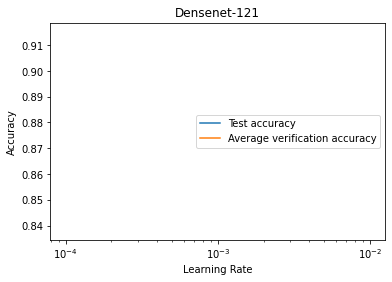

test_acc_list[0.9149159663865547]
verification accuracy[0.8382352941176471]


In [ ]:
import torch
import matplotlib.pyplot as plt

if __name__ == '__main__':
    end = time.time()
    model_ft = DenseNet().to(device) # Model initialization
    #print(model_ft.network)
    criterion = nn.CrossEntropyLoss() # Loss function initialization

    lr_list=[1e-3]
    test_acc_list=[]
    validation_acc_list=[]
    validation_acc_category_list = []

    
    for i in lr_list:

      # TODO: Adjust the following hyper-parameters: initial learning rate, decay strategy of the learning rate, number of training epochs
      optimizer_ft = torch.optim.Adam(model_ft.parameters(), lr=i) # The initial learning rate is 1e-3

      exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=2.5, gamma=0.5) # Decay strategy of the learning rate

      
      history, accuracy = train_test(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=60)# The number of training epochs is 25
      test_acc_list.append(history['train_accuracy'][-1]/100)
      validation_acc_list.append((sum(accuracy.values())/17))
      validation_acc_category_list = accuracy
      
      print("Learning rate", i)
      print("time required %.2fs"%(time.time() - end))
      print("Average verification accuracy %.2fpercent"%(sum(accuracy.values())/17))
      print("test_accuracy_epochs"+str(history['train_accuracy']))
      print("\n\n\n")
    
plt.plot(lr_list, test_acc_list,label="Test accuracy")
plt.plot(lr_list,validation_acc_list,label="Average verification accuracy")
plt.title("Densenet-121")
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xscale("log")
plt.legend()
plt.show()
print("test_acc_list"+str(test_acc_list))
print("verification accuracy"+str(validation_acc_list))

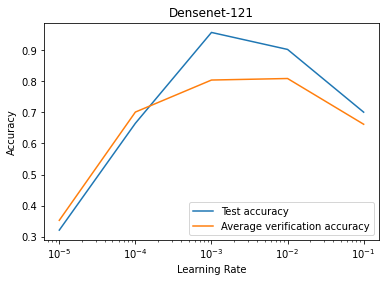

test_acc_list[0.32142857142857145, 0.6649159663865547, 0.9569327731092437, 0.9023109243697479, 0.7006302521008404]
verification accuracy[0.35294117647058826, 0.7009803921568626, 0.803921568627451, 0.8088235294117649, 0.6617647058823528]


In [ ]:
plt.plot(lr_list, test_acc_list,label="Test accuracy")
plt.plot(lr_list,validation_acc_list,label="Average verification accuracy")
plt.title("Densenet-121")
plt.xlabel('Learning Rate')
plt.ylabel('Accuracy')
plt.xscale("log")
plt.legend()
plt.show()
print("test_acc_list"+str(test_acc_list))
print("verification accuracy"+str(validation_acc_list))

In [ ]:
# history

scores = [0.34558823529411764,0.4632352941176471,0.375,0.45588235294117646,0.4485294117647059,0.6691176470588235,0.625,0.6911764705882353,0.6764705882352942,0.7205882352941176,0.7794117647058824,0.7647058823529411,0.7426470588235294,0.7720588235294118,0.7205882352941176,0.7794117647058824,0.8014705882352942,0.7941176470588235,0.7941176470588235,0.8308823529411765,0.8014705882352942,0.8455882352941176,0.8382352941176471,0.8382352941176471,0.8529411764705882,0.8308823529411765,0.8529411764705882,0.8308823529411765,0.8455882352941176,0.8235294117647058,0.8308823529411765,0.8382352941176471,0.8235294117647058,0.8529411764705882,0.8382352941176471,0.8455882352941176,0.8602941176470589,0.8455882352941176,0.8382352941176471,0.8308823529411765,0.8455882352941176,0.8382352941176471,0.8676470588235294,0.8088235294117647,0.8382352941176471,0.8308823529411765,0.8529411764705882,0.8602941176470589,0.8382352941176471,0.8455882352941176,0.8455882352941176,0.8455882352941176,0.8529411764705882,0.8602941176470589,0.8529411764705882,0.8602941176470589,0.8455882352941176,0.8529411764705882,0.8382352941176471,0.8382352941176471]
for i, num in enumerate(scores):
  print(i+1, num)

1 0.34558823529411764
2 0.4632352941176471
3 0.375
4 0.45588235294117646
5 0.4485294117647059
6 0.6691176470588235
7 0.625
8 0.6911764705882353
9 0.6764705882352942
10 0.7205882352941176
11 0.7794117647058824
12 0.7647058823529411
13 0.7426470588235294
14 0.7720588235294118
15 0.7205882352941176
16 0.7794117647058824
17 0.8014705882352942
18 0.7941176470588235
19 0.7941176470588235
20 0.8308823529411765
21 0.8014705882352942
22 0.8455882352941176
23 0.8382352941176471
24 0.8382352941176471
25 0.8529411764705882
26 0.8308823529411765
27 0.8529411764705882
28 0.8308823529411765
29 0.8455882352941176
30 0.8235294117647058
31 0.8308823529411765
32 0.8382352941176471
33 0.8235294117647058
34 0.8529411764705882
35 0.8382352941176471
36 0.8455882352941176
37 0.8602941176470589
38 0.8455882352941176
39 0.8382352941176471
40 0.8308823529411765
41 0.8455882352941176
42 0.8382352941176471
43 0.8676470588235294
44 0.8088235294117647
45 0.8382352941176471
46 0.8308823529411765
47 0.8529411764705882

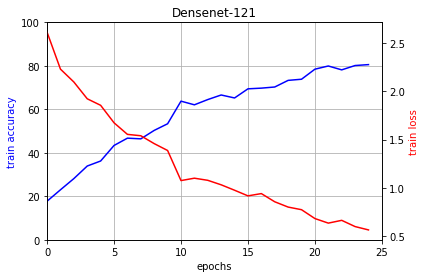

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

num_epochs = 25

# Data for plotting
train_accuracy = history["train_accuracy"]
train_loss = history["train_loss"]
epochs = range(0, num_epochs)
fig, ax = plt.subplots()
ax.plot(epochs, train_accuracy, color="blue")

ax.set(xlabel='epochs', ylabel='train accuracy', title='Densenet-121')
ax.set_ylabel("train accuracy", color="blue")
ax.set_ylim([0, 100])
ax.set_xlim([0, num_epochs])
ax.grid()

# twin object for two different y-axis on the sample plot
ax2=ax.twinx()
# make a plot with different y-axis using second axis object
ax2.plot(epochs, train_loss, color="red")
ax2.set_ylabel("train loss", color="red")


fig.savefig("densenet3.png")
plt.show()

In [ ]:
accuracy

{'Bluebell': 1.0,
 'Buttercup': 1.0,
 "Colts'Foot": 0.9166666666666667,
 'Cowslip': 0.5833333333333334,
 'Crocus': 0.6666666666666667,
 'Daffodil': 0.5,
 'Daisy': 0.9166666666666667,
 'Dandelion': 0.8333333333333333,
 'Fritillary': 0.9166666666666667,
 'Iris': 0.8333333333333333,
 'LilyValley': 0.9166666666666667,
 'Pansy': 0.75,
 'Snowdrop': 0.75,
 'Sunflower': 1.0,
 'Tigerlily': 1.0,
 'Tulip': 0.5833333333333334,
 'Windflower': 0.9166666666666667}

In [ ]:
# Store model accuracy in json for future reference
import json
 
model_name = "densenet2"
dictionary = {
    model_name: history
}
 
# Serializing json
json_object = json.dumps(dictionary, indent=2)
 
# Writing output
with open("densenet3.json", "w") as outfile:
    outfile.write(json_object)

In [ ]:
# save model for future
torch.save(model_ft, "/content/densenet-121-3rd-83%.pt")